## Imports 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import math

from pyteomics import fasta
from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra
from src.postprocessing import review
from src import utils

# Multiple datasets post analysis
Run multiple data sets and do some post processing to see how well we do overall

### Define the data

In [2]:
# define the list of datasets
# make it a list of tuples of (mzml, spectrum mill *sv, database, prefix dir)
raw_prefix = '/Users/zacharymcgrath/Desktop/raw inputs/'
NOD2_data = (
    raw_prefix + 'NOD2_E3/NOD2_E3.mzML', 
    raw_prefix + 'NOD2_E3/NOD2_E3_results.ssv', 
    raw_prefix + 'mouse_database.fasta',
    raw_prefix + 'NOD2_E3/'
)

BALB3_data = (
    raw_prefix + 'BALB3_E3/BALB3_E3.mzML', 
    raw_prefix + 'BALB3_E3/BALB3_E3.ssv', 
    raw_prefix + 'mouse_database.fasta',
    raw_prefix + 'BALB3_E3/'
)

datasets = [NOD2_data, BALB3_data]


### Filter the data
We don't care about the spectra that don't get matches in spectrumMill because we need something to compare to. Additionally, create a filtered database for just the proteins that are found in the results

In [37]:
def db_filter(db_file: str, results_file: str, output_fasta: str) -> None:
    '''
    Create the subset of proteins needed for the database search
    
    Inputs:
        db_file:        (str)  the original fasta file
        results_file:   (str)  the results ssv file from spectrumMill
        output_fasta:   (str)  the fasta file to write to
    '''
    
    # load all protiens into a dictionary
    db = {}
    for entry in fasta.read(db_file):
        name = entry.description.split('|')[2]
        name = name[:name.index('OS=')-1]
        name = ' '.join(name.split(' ')[1:])
        db[name.lower()] = entry

    # load the results ssv into a dataframe 
    res_df = pd.read_csv(results_file, sep=';')
    
    print(res_df.columns)
    
    print(f'Number of results: {len(res_df.index)}')

    # keep track of those we want
    filtered = []
    for idx, row in res_df.iterrows():
        key = row['entry_name'].lower()
        
        if key not in db:
            continue
            
        filtered.append(db[key])

    filtered = list(set(filtered))
    
    print(f'Number of proteins in database was reduced from {len(db)} to {len(filtered)}')
    
    fasta.write(filtered, output_fasta, file_mode='w')

In [38]:
updated_datasets = []

for dataset in datasets:
        
    # make a file name for the output
    output_fasta = dataset[-1] + 'filtered_' + os.path.basename(dataset[1])
    
    db_filter(dataset[2], dataset[1], output_fasta)
    
    updated_datasets.append((*dataset, output_fasta))

datasets = updated_datasets

Index(['number', 'filename', 'parent_charge', 'score',
       'deltaForwardReverseScore', 'deltaRank1Rank2Score',
       'percent_scored_peak_intensity', 'totalIntensity', 'previous_aa',
       'sequence', 'next_aa', 'retentionTimeMin',
       'chromatographicPeakWidthSec', 'parent_m_over_z', 'species',
       'entry_name'],
      dtype='object')
Number of results: 1086
Number of proteins in database was reduced from 17028 to 279
Index(['number', 'filename', 'parent_charge', 'score', 'deltaRank1Rank2Score',
       'percent_scored_peak_intensity', 'num_unused_ions', 'totalIntensity',
       'previous_aa', 'sequence', 'next_aa', 'sequenceMap', 'modifications',
       'retentionTimeMin', 'chromatographicPeakWidthSec', 'parent_m_over_z',
       'entry_name'],
      dtype='object')
Number of results: 971
Number of proteins in database was reduced from 17028 to 228


### Now run hyped search

In [5]:
min_pep = 3
max_pep = 30
tolerance = 20
precursor_tolerance = 10
peak_filter = 25
relative_abundance_filter = 0

for dataset in datasets:
        
    run_params = {
        'spectra_folder': dataset[3],
        'database_file': dataset[-1],
        'output_dir': dataset[3] + 'output/',
        'min_peptide_len': min_pep,
        'max_peptide_len': max_pep,
        'tolerance': tolerance,
        'precursor_tolerance': precursor_tolerance,
        'peak_filter': peak_filter, 
        'relative_abundance_filter': relative_abundance_filter,
        'digest': '', 
        'missed_cleavages': 0,
        'verbose': True,
        'DEBUG': False,
        'cores': 16,
        'truth_set': '', 
        'n': 100
    }

    runner.run(run_params)
    
    print()

Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 279/279 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/output/...
Could not make an alignment for 1/1086 spectra (0%)

Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 228/228 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 12165/12166 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/raw inputs/BALB3_E3/output/...
Could not make an alignment for 1091/12166 spectra (8%)



### Keep track of the output data location

In [22]:
output_data = [
    x[3] + 'output/summary.json' for x in datasets
]


### For each of the datasets, find out where the correct answer fell (no ties)

In [17]:
def dictify_table(df: pd.DataFrame, key: str) -> dict:
    '''
    Turn a pandas dataframe into a dictionary where the indices are the key specified
    '''
    ret_dict = {}
    
    for idx, row in df.iterrows():
        ret_dict[row[key]] = dict(row)
    
    return ret_dict

In [31]:
results = defaultdict(lambda: 0)

individual_results = [defaultdict(lambda: 0) for _ in range(len(datasets))]

nf_key = 'not found'
na_key = 'no alignment'

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    nf = []
    na = []
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
        
    # index hypedSearch_results by the id value in key, value value['spectrum']
    hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    
    print(hypedSearch_results.keys())
    
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            nf.append(key)
            results[nf_key] += 1
            individual_results[j][nf_key] += 1
            continue 
            
        found = False
                    
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            comp_sequence = alignment['sequence']
            
            # if hybrid, replace L and I with B
            if hybrid:
                comp_sequence = comp_sequence.replace('L', 'B').replace('I', 'B')
            
            if comp_sequence == correct_sequence:
                results[str(i)] += 1
                individual_results[j][str(i)] += 1
                found = True
                
        if not found:
            na.append(key)
            results[na_key] += 1
            individual_results[j][na_key] += 1
            
#     print(f'Ids not found for {dataset[0]}:\n{nf}')
#     print(f'Ids with no alignment for {dataset[0]}:\n{na}')
    

dict_keys(['NOD2_E3.13446.13477.2', 'NOD2_E3.15226.15503.2', 'NOD2_E3.18005.18246.2', 'NOD2_E3.7065.7065.2', 'NOD2_E3.10635.10674.3', 'NOD2_E3.10614.10681.2', 'NOD2_E3.5978.6049.2', 'NOD2_E3.16920.17393.2', 'NOD2_E3.21510.21510.2', 'NOD2_E3.16373.16401.2', 'NOD2_E3.10121.10155.2', 'NOD2_E3.17517.17517.3', 'NOD2_E3.18104.18104.3', 'NOD2_E3.13729.13828.2', 'NOD2_E3.11427.11516.2', 'NOD2_E3.11316.11435.2', 'NOD2_E3.8131.8207.2', 'NOD2_E3.9670.9702.4', 'NOD2_E3.17615.17744.2', 'NOD2_E3.12771.12902.3', 'NOD2_E3.9365.9365.2', 'NOD2_E3.10980.11010.2', 'NOD2_E3.5028.5028.3', 'NOD2_E3.15658.15779.2', 'NOD2_E3.6072.6137.2', 'NOD2_E3.17821.17855.2', 'NOD2_E3.3820.3820.5', 'NOD2_E3.4133.4133.3', 'NOD2_E3.5288.5288.5', 'NOD2_E3.3808.3850.4', 'NOD2_E3.4632.4632.3', 'NOD2_E3.17256.17256.4', 'NOD2_E3.7225.7225.4', 'NOD2_E3.7996.7996.5', 'NOD2_E3.17804.17804.3', 'NOD2_E3.10997.11035.3', 'NOD2_E3.8803.8803.3', 'NOD2_E3.14557.14557.2', 'NOD2_E3.12220.12676.2', 'NOD2_E3.15763.15763.2', 'NOD2_E3.14834.1483

dict_keys(['scan=4', 'scan=16', 'scan=11', 'scan=10', 'scan=1', 'scan=20', 'scan=9', 'scan=22', 'scan=21', 'scan=24', 'scan=23', 'scan=13', 'scan=26', 'scan=2', 'scan=27', 'scan=30', 'scan=31', 'scan=17', 'scan=14', 'scan=6', 'scan=35', 'scan=33', 'scan=36', 'scan=29', 'scan=28', 'scan=39', 'scan=38', 'scan=18', 'scan=12', 'scan=43', 'scan=40', 'scan=8', 'scan=46', 'scan=48', 'scan=49', 'scan=25', 'scan=41', 'scan=34', 'scan=45', 'scan=5', 'scan=50', 'scan=55', 'scan=52', 'scan=58', 'scan=53', 'scan=57', 'scan=60', 'scan=61', 'scan=62', 'scan=44', 'scan=59', 'scan=63', 'scan=67', 'scan=68', 'scan=15', 'scan=66', 'scan=65', 'scan=70', 'scan=19', 'scan=71', 'scan=75', 'scan=51', 'scan=74', 'scan=47', 'scan=78', 'scan=80', 'scan=69', 'scan=82', 'scan=72', 'scan=81', 'scan=83', 'scan=86', 'scan=32', 'scan=87', 'scan=42', 'scan=56', 'scan=90', 'scan=92', 'scan=89', 'scan=54', 'scan=94', 'scan=95', 'scan=88', 'scan=96', 'scan=79', 'scan=98', 'scan=100', 'scan=101', 'scan=103', 'scan=104', 's

### Plot it by all results

In [28]:
sorted_int_keys = sorted([x for x in list(results.keys()) if x.isdigit()], key=lambda x: int(x))
non_int_keys = [x for x in list(results.keys()) if not x.isdigit()]

Text(0.5, 1.0, 'Number of results with a ranking for all datasets')

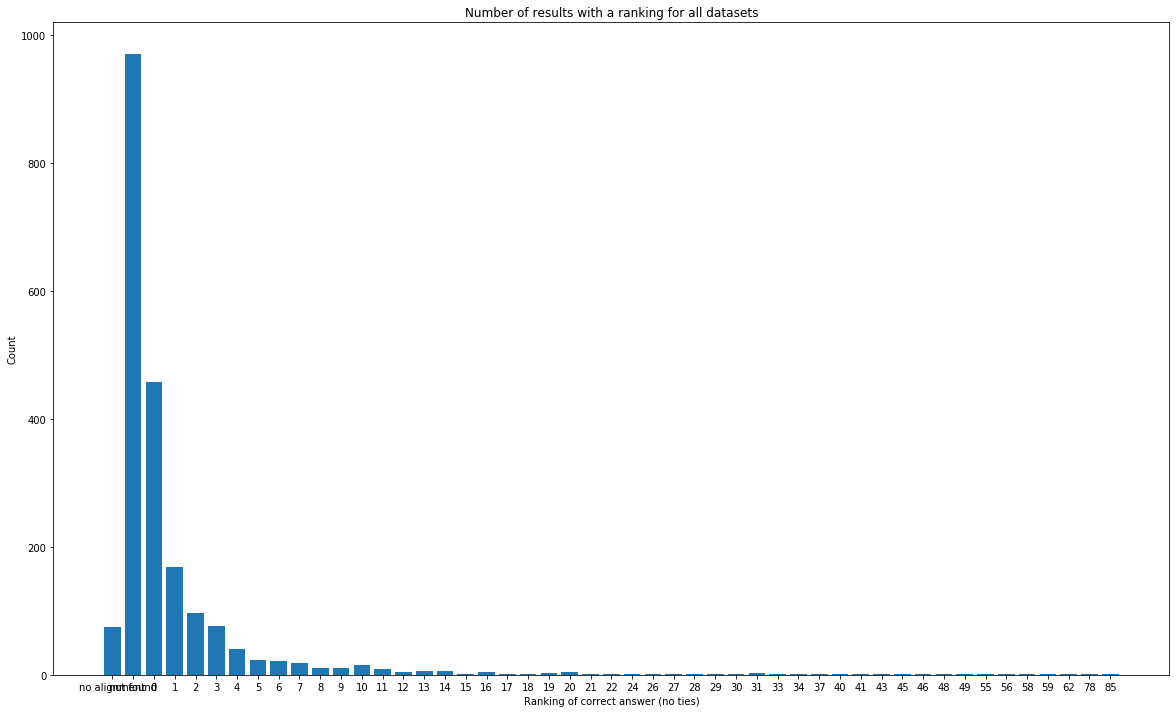

In [29]:
plt.figure(figsize=(20, 12))

plt.bar(non_int_keys + sorted_int_keys, [results[k] for k in non_int_keys] + [results[k] for k in sorted_int_keys])
plt.xlabel('Ranking of correct answer (no ties)')
plt.ylabel('Count')
plt.title('Number of results with a ranking for all datasets')

### Plot it by the dataset

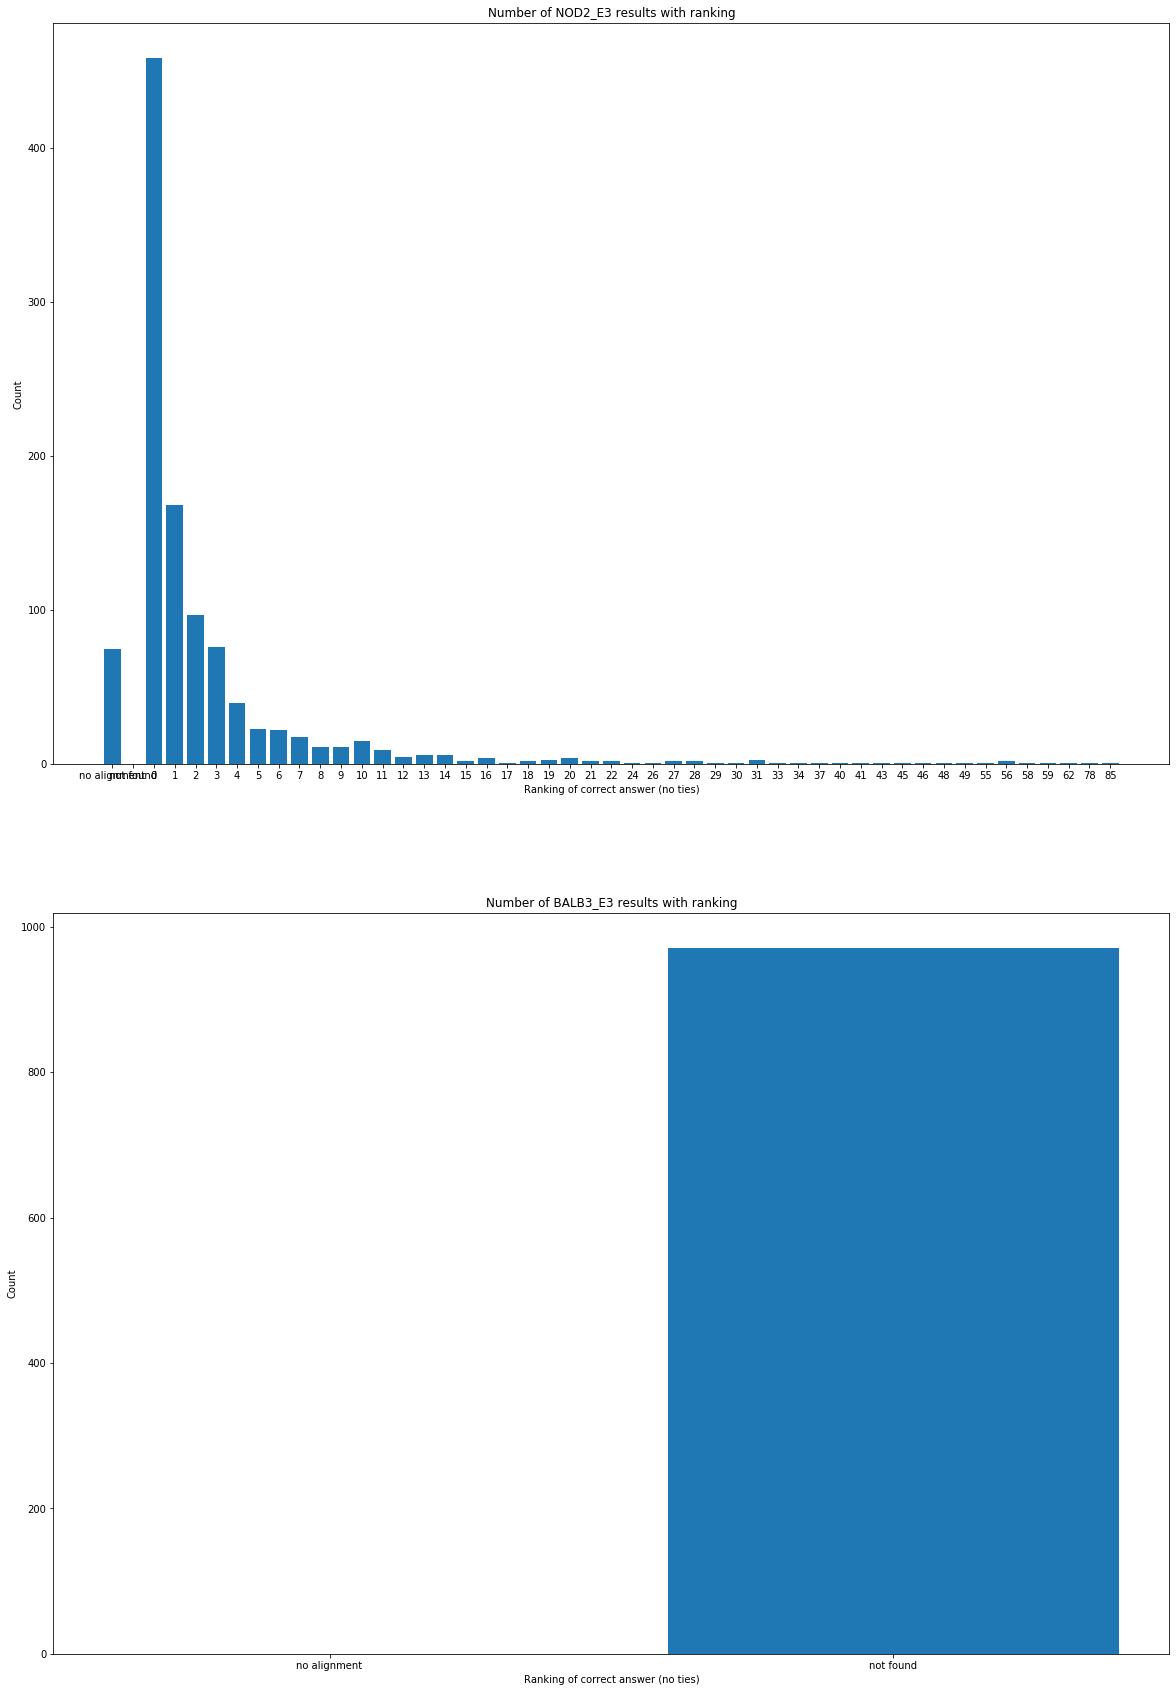

In [30]:
fig, axes = plt.subplots(len(individual_results), 1, figsize=(20, 15*len(individual_results)))

for i, ir in enumerate(individual_results):
    
    # first get the title
    title = datasets[i][0].split('/')[-1].split('.')[0]
    title = f'Number of {title} results with ranking'
    
    # get the keys
    ir_sik = sorted([x for x in list(ir.keys()) if x.isdigit()], key=lambda x: int(x))
    ir_nik = [x for x in list(results.keys()) if not x.isdigit()]
    
    axes[i].bar(ir_nik + ir_sik, [ir[k] for k in ir_nik] + [results[k] for k in ir_sik])
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Ranking of correct answer (no ties)')
    axes[i].set_ylabel('Count')